In [24]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from Bio import SeqIO

from pyutils.constants import (
    OUTPUT_DIR,
    PLOTS_DIR,
    REF_SEQS,
    SRA_SUMMARY_FILE,
)

In [2]:
BASE_COLORS = {
    '-': 'grey',
    'N': 'black',
    'A': 'red',
    'T': 'green',
    'G': 'blue',
    'C': 'orange'
}

In [3]:
sra_summary = pd.read_csv(SRA_SUMMARY_FILE)

In [4]:
all_mutation_summary = {}

for _, row in sra_summary.iterrows():
    exp_name = row['Experiment Title']
    if exp_name in REF_SEQS:
        sra_id = row['Run']
        experiment_dir = os.path.join(OUTPUT_DIR, exp_name.replace(' ', '_'))
        refseq = SeqIO.read(
            os.path.join(experiment_dir, 'refseq.fasta'),
            'fasta'
        )
        work_dir = os.path.join(OUTPUT_DIR, experiment_dir, sra_id)
        if os.path.exists(work_dir):
            mutation_summary_df = pd.read_csv(
                os.path.join(work_dir, f'{sra_id}_base_freq.csv'),
                index_col=0
            )
            mutation_summary_df.columns = mutation_summary_df.columns.astype(
                int)
            mutation_summary_df.loc['total'] = mutation_summary_df.sum(0)
            all_mutation_summary[sra_id] = mutation_summary_df
            # break

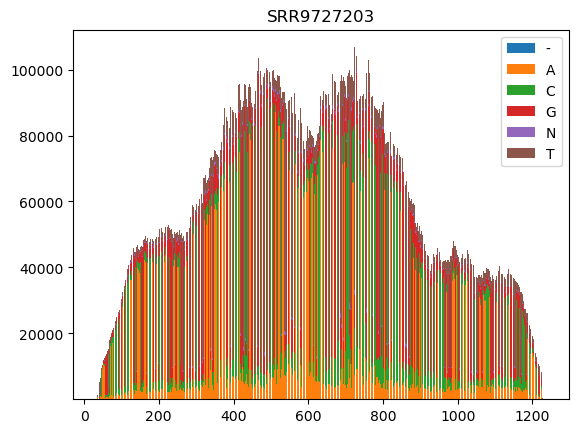

In [5]:
bottom = np.zeros(len(mutation_summary_df.columns))

for base, row in mutation_summary_df.iterrows():
    if base != 'total':
        plt.bar(mutation_summary_df.columns, row.values, label=base, bottom=bottom)
        bottom += row.values

plt.title(sra_id)
plt.legend()
plt.show()

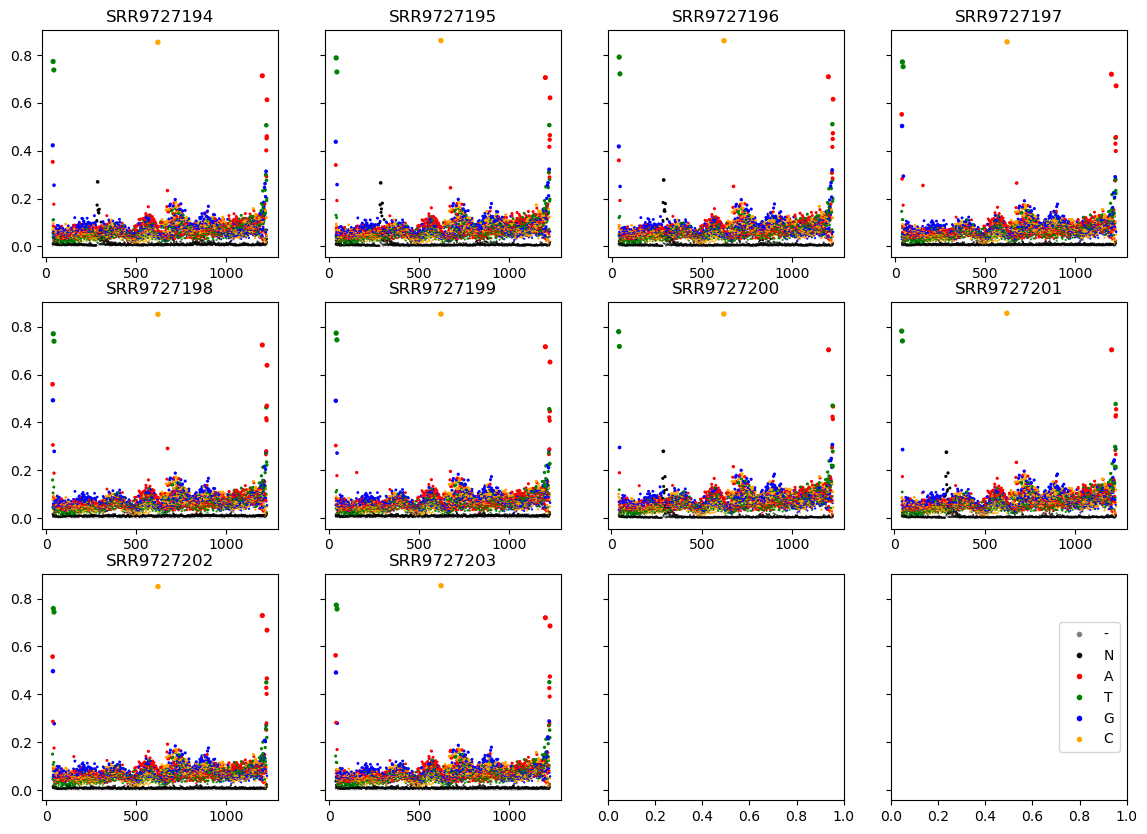

In [41]:
nrows = 3
ncols = 4

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    # sharex=True,
    sharey=True,
    figsize=(3.5 * ncols, 10)
)

i, j = 0, 0
for sra_id, df in all_mutation_summary.items():
    ax = axes[i][j]
    j += 1
    if j == ncols:
        i += 1
        j = 0
    df_filterd = df[df.columns[
        df.loc['total'] > 1000
    ]].copy()

    for site, base in enumerate(refseq, start=1):
        base = base.upper()
        if site in df_filterd.columns:
            ref = df_filterd.loc[base, site]
            df_filterd.at[base, site] = 0
            df_filterd.at['ref', site] = ref

    bottom = np.zeros(len(df_filterd.columns))
    mut_ratio = df_filterd / df_filterd.loc['total']
    mut_ratio = mut_ratio.drop(index=['total', 'ref'])
    mut_ratio = mut_ratio.unstack().reset_index()
    mut_ratio.columns = ['site', 'base', 'freq']
    mut_ratio = mut_ratio[mut_ratio['freq'] != 0]
    mut_ratio = mut_ratio.sort_values('freq')

    ax.scatter(
        mut_ratio['site'],
        mut_ratio['freq'],
        s=10 * mut_ratio['freq'],
        # alpha=mut_ratio['freq'],
        c=[BASE_COLORS[base_l] for base_l in mut_ratio['base']],
    )
    ax.set_title(sra_id)
    # ax.stem(mut_ratio.columns, row.values, markerfmt=' ', label=base)

plt.legend(
    handles=[
        mlines.Line2D([], [], color=c, marker='.', linestyle='None', label=l)
        for l, c in BASE_COLORS.items()
    ],
    loc='center right'
)
plt.savefig(os.path.join(PLOTS_DIR, 'MEK1.pdf'))
plt.show()
plt.close()